# Kaggle Comp - Classical Music Meets Classical ML

## Assignment 

- https://www.kaggle.com/competitions/classical-music-meets-clasical-ml-spring-2025/data

### Data
- Our task is to build a model to predict which previous patrons will purchase
a subscription to the 2014-15 concert season
- We are given a subset of patrons along with a 0/1 label indicating whether they
purchased a 2014-15 season subscription (train.csv)
- We are given a test set containing accounts to generate predictions (test.csv)
- We are also given several other datafiles:
    - Account.csv: location info for each patron and donation history
    - Tickets_all.csv: previously purchased tickets by account - season, location, set, price level, # seats
    - Subscriptions.csv: previously purchased subscriptions by account – season, location, price level, # seats
    - Concerts.csv: previous concerts by season – title, composer, location
    - Concerts_2014-15.csv: list of planned 2014-15 sets
    - zipcodes.csv: information about zip codes

### Approach
- Determine possible features
- Create a data pipeline to build features (both train and test)
    - Clean data
    - Generate features
    - Prepare data for modeling
- Perform modeling (validation approach) 
    - Feature engineering & selection
    - Evaluate algorithms
    - Tune hyperparameters
    - Possibly create ensembles

### Scoring
- We will use AUROC to score your probabilistic predictions
  - Kaggle will automatically calculate it for you when you upload your predictions
- Test set is divided into public and private test sets
- Public leaderboard will show your performance on the public test set
- Your final leaderboard position will depend on the private test set
    - This prevents any attempt to “game the system”
- Your grade will be calculated based on your private test set performance
- Your grade will depend on three parts:
    – Your score on the private test set (70 points)
    – Your code hygiene (10 points)
        - All submission code must be in python scripts (no notebooks)
        - Code should be organized (functions & classes), no loose code
        - Code should be easy to follow and reasonably documented (docstrings for
functions and classes)
    - Your writeup of your modeling process (20 points)
        - README doc describing your data pipeline and modeling approach
        - Must be understandable and sufficiently detailed

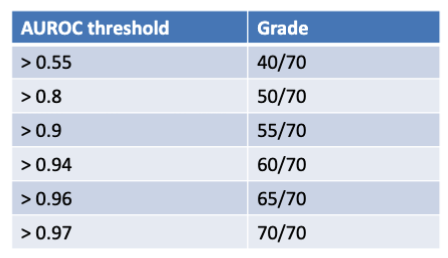

## Data

For each dataset, understand what's furnished, clean it, and encode any categoricals for to allow for correlation matrix, pairplot, etc... to help understand distribution, etc... (we can't do a distribution on a column of strings). 

❗️ A heuristic search of the predictors, normalization, encoding, engineered features, hyperparameters,...  seems inefficient and unlikely to yield good results in particular due to my lack of appreciation of the underlying domain. Perhaps the box office could tell you that county of residence and a love of vivaldi are the most likely inputs to correlate with subscriptions, but I can't. It will be a lot less work and a lot more fun to leave the search to the computer. So, when there is a decision, for example how to treat international zip codes, instead of picking a path and then hoping I remember to come back and run an experiment on the alternative path, code both as potential configurations or inputs that we can iterate over to find the optimal setup. 
- We could bias toward building a cuckoo-bananas-big dataframe with all the possible features in it and letting L1 regularization crush the unhelpful inputs
- We could somehow keep running tabs of these alternatives and exhaustively search all the permutations for the best outcome
- We could build a model to select the principle components and train on those

Whatever we do, don't lose track of these decisions and ensure they are explored automatically. It's possible we'll get everything dialed in and then realize we missed a key insight or optimization and we'll need to reun all the alternatives again. The easiest thing to start with is the CBBDF, just keep adding columns, we can optimize them away later but this gives us an easy option for running a correlation matrix, heatmap, etc... 
- However, the CBBDF doesn't help us integrate some of the data which has a 1-many relationship with the accounts. for example, account xyz might have purchased 20 tickets last year, have various historical donations and be on a marketing list twice... how does this get rolled up in to the CBBDF? lots of decisions to be made here.
    - do historical ticket purchases get rolled up into one number? what about the timing of those purchases? you could have had a benefactor 5 years ago that died but the temporal component of the donations is lost when you aggregate in such a naive way 
    - if we sum historical subscription info, we lose the location, price level, section and sub tier of each ... surely this information is relevant, or at least it coudl be and excluding seems short-sighted.

❗️ To do: 
 - get all data into numerical format to enable basic predictions
 - decide whether all data needs to be standardized

**Data Model** 

We are interested in predicting purchase probability, based solely on the account number of the customer. At the highest level we have then 
- an account, which has exactly one of each of the following features in the dataset
    - id
    - zip (it feels safe to collapse shipping zip, billing zip into a single, normalized value)
    - city (could conflict with zip, but i think it's safe to collapse this into the city yielded by the ZIP lookup whether or not they match)
    - relationship - categorical, nature of relationship to business
    - amount donated last year
    - amount donated lifetime
    - number of lifetime donations
    - date first donated
... and $0 - k$ of these
    - subscriptions, list of prior subscriptions - longer history than tickets but overlaps
        - season
        - package
        - number of seats
        - location
        - section
        - price
        - tier
        - multiple subscription indicator
    - tickets, list of prior purchases - only runs for a few years
        - price,
        - number of seats
        - marking sourc
        - season
        - location
        - set (maps to concert info given the season above) 
        - multiple ticket buyer indicator

Reference info that extends one or more of above, but doesn't change dimensionality
- concerts, historical listing of concerts with
    - season 
    - concert name
    - who performed it
    - what was performed
    - where it was performed (of the few locs possible)
- zip reference, which has one of each of the following relevant features
    - Zipcode
    - ZipCodeType
    - City
    - State
    - Lat
    - Long
    - Decommisioned
    - TaxReturnsFiled
    - EstimatedPopulation
    - TotalWages

We have to assume that tickets are individual purchases or additional seats for guests, and that subscriptions guarantee the subscriber some number of seats or a reserved seat at every performance. 
 
And the following information which seems to be floating in space. This isn't associated with any subscriber, but their prior history is what should condition the likelihood that they'll buy this year. So, like $P(subscribe|concerts)$. We do have *some* labeled data for this concert season, that could be what we train a bayesian model on. 

- concerts coming up
    - concert name
    - who is performing
    - what is being performed
    - where 

In [1]:
!ls data

account.csv           sample_submission.csv train.csv
account_clean.csv     subscriptions.csv     zipcodes.csv
concerts.csv          test.csv
concerts_2014-15.csv  tickets_all.csv


In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

### Train Set

In [3]:
# Subset of accounts/patrons and whether they purchased a 2014-2015 subscription
train_df = pd.read_csv('data/train.csv', index_col='account.id')
train_df.head() 

,label
account.id,
001i000000NuRo3,0
001i000000NuRxd,0
001i000000NuQGN,0
001i000000NuPfL,0
001i000000NuQkP,0


In [4]:
train_df.dtypes

label    int64
dtype: object

In [5]:
train_df.count()

label    6941
dtype: int64

In [6]:
train_df[train_df['label']==1].count()

label    332
dtype: int64

In [7]:
# Super imbalanced classes here...

### Predict Set

In [8]:
# Test set containing accounts to generate predictions for 
test_df = pd.read_csv('data/test.csv', index_col='ID') 
test_df.head()

""
ID
001i000000NuQ6Y
001i000000NuQXz
001i000000NuRDC
001i000000NuQeg
001i000000NuOQc


In [9]:
test_df.dtypes

Series([], dtype: object)

In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2975 entries, 001i000000NuQ6Y to 001i000000NuOAN
Empty DataFrame


### Zip code reference

**Feature audit** 
- ZipCodeType
    - one of standard, DPO, PO BOX...
- LocationType
    - Can be dropped, just a single value
- Lat/long
- Location
    - Coding for continent, country, state, city
    - Drop this
- Decommissioned
    - Binary, some number of zip codes are apparently no longer used
    - 663 of 41K+
- TaxReturnsFiled
- EstimatedPop
    - Seems plausible
    - for 27603 reports 19277 tax returns, 33789 population and 836M in total wages
- TotalWages
    - ~30K zip codes report this and the two features above... what are they?
    - Blanks aren't correlated with the states
    - Wages/population seems like a great feature to engineer...

In [11]:
zip_df = pd.read_csv('data/zipcodes.csv') 
display(zip_df.head())
display(zip_df.tail())

,Zipcode,ZipCodeType,City,State,LocationType,Lat,Long,Location,Decommisioned,TaxReturnsFiled,EstimatedPopulation,TotalWages
0,705,STANDARD,AIBONITO,PR,PRIMARY,18.14,-66.26,NA-US-PR-AIBONITO,False,NaN,NaN,NaN
1,610,STANDARD,ANASCO,PR,PRIMARY,18.28,-67.14,NA-US-PR-ANASCO,False,NaN,NaN,NaN
2,611,PO BOX,ANGELES,PR,PRIMARY,18.28,-66.79,NA-US-PR-ANGELES,False,NaN,NaN,NaN
3,612,STANDARD,ARECIBO,PR,PRIMARY,18.45,-66.73,NA-US-PR-ARECIBO,False,NaN,NaN,NaN
4,601,STANDARD,ADJUNTAS,PR,PRIMARY,18.16,-66.72,NA-US-PR-ADJUNTAS,False,NaN,NaN,NaN


,Zipcode,ZipCodeType,City,State,LocationType,Lat,Long,Location,Decommisioned,TaxReturnsFiled,EstimatedPopulation,TotalWages
42517,34009,MILITARY,APO,AA,PRIMARY,NaN,NaN,SA-GY-NEW HORIZON-GUYANA,True,NaN,NaN,NaN
42518,34010,MILITARY,APO,AA,PRIMARY,NaN,NaN,CA-HN-NEW HORIZON LA CEIBA - COMAYAGUA,True,NaN,NaN,NaN
42519,34001,MILITARY,APO,AA,PRIMARY,NaN,NaN,CA-NI-JTF JUNTOS PODEMOS BASE CAMP,True,NaN,NaN,NaN
42520,34071,MILITARY,APO,AA,PRIMARY,NaN,NaN,SA-PY-JTF NEW HORIZON-CONCEPCION,True,NaN,NaN,NaN
42521,97475,PO BOX,SPRINGFIELD,OR,PRIMARY,44.05,-123.02,NA-US-OR-SPRINGFIELD,False,NaN,NaN,NaN


In [12]:
zip_df.columns

Index(['Zipcode', 'ZipCodeType', 'City', 'State', 'LocationType', 'Lat',
       'Long', 'Location', 'Decommisioned', 'TaxReturnsFiled',
       'EstimatedPopulation', 'TotalWages'],
      dtype='object')

In [13]:
zip_df.dtypes

Zipcode                  int64
ZipCodeType             object
City                    object
State                   object
LocationType            object
Lat                    float64
Long                   float64
Location                object
Decommisioned             bool
TaxReturnsFiled        float64
EstimatedPopulation    float64
TotalWages             float64
dtype: object

In [14]:
def canonicalize_zip(zip, print_invalid=False) -> int: 
    out = 0
        
    if int == type(zip): 
        if zip > 0 and zip < 99950: 
            out = zip
        else: 
            pass 
            
    if str == type(zip):
        
        if zip.isdigit(): 
            # 3-digit ZIP (PR) missing the leading zeros 
            if len(zip) == 3: 
                out = int(zip) 
            
            # 4-digit missing a leading zero (e.g. some NJ, mass zips)
            elif len(zip) == 4: 
                out = int(zip) 
                
            # 5-digit ZIP
            elif len(zip) == 5: 
                out = int(zip) 

            else: 
                pass
                
        elif len(zip) > 5 and zip[5] == '-':
            out = int(zip[0:5]) 

        else: 
            
            pass
    else: 
        pass 

    if out is None and print_invalid: 
        print(f"Ignoring unknown ZIP format:{zip}")

    return(out) 

def code_international(zip) -> bool: 
    intl = 0
        
    if str == type(zip):
        if not zip.isdigit(): 
            intl = 1
            if len(zip) == 10 and zip[5] == '-':
                intl = 0

    return(intl) 

In [15]:
zip_df['Zipcode'].apply(canonicalize_zip, args=[True]) 

0          705
1          610
2          611
3          612
4          601
         ...  
42517    34009
42518    34010
42519    34001
42520    34071
42521    97475
Name: Zipcode, Length: 42522, dtype: int64

In [16]:
# All zips here are healthy, no massaging required

In [17]:
zip_df['ZipCodeType'].unique()

array(['STANDARD', 'PO BOX', 'UNIQUE', 'MILITARY'], dtype=object)

In [18]:
zip_df['TaxReturnsFiled'].unique()

array([   nan, 13245.,  2945., ...,  1289., 24012., 15865.])

In [19]:
zip_df['EstimatedPopulation'].unique()

array([   nan, 24083.,  5471., ..., 29471., 43717., 30483.])

In [20]:
zip_df['TotalWages'].unique()

array([           nan, 1.08909504e+09, 3.25436960e+08, ...,
       8.82055221e+08, 4.38123710e+07, 6.71941190e+07])

In [21]:
zip_df.drop(['Decommisioned'], axis=1, inplace=True)

### Patron location and donation history

**Feature summary**  
- Shipping ZIP:
    - where they are alphnumeric, they correspond to a non-US location, which could be an important signal ... if we do an inner join with the ZIP data we'll lose this information, as there is no reference info for foreign mailing codes 
    - maybe 1% of the rows have these listed!
- Billing ZIPs:
    - same here as above, try to preserve the foreign residence if we join with ZIP... perhaps a separate column (international)
    - maybe 70% of rows include a billing zip
- Shipping city:
    - These entries almost always have an associated shipping ZIP
    - Maybe 1% of entries include this info
- Billing city:
    - Similar to billing ZIP in terms of prevalnce
    - Almost always have a billing ZIP

- A number of these accounts are blank in both ZIP columns
    - maybe 20% of the accounts -- we can't reject these!
    - a number have foreign addresses in billing city, e.g. 'Brumadinho, MG', 'Halifax', 'Kwun Tong'
- Relationship:
    - There are just a handful of `relationship` categories, we could one-hot encode these, but man this doesn't scale well... we'll have super sparse and confusing DFs if we one-hot encode everything. Maybe this is a decision point we should track? I.e. build a pipeline that can do alternative encodings in the future if we want?
        - How about the sklearn.OneHotEncoder, etc... can we chain together sklearn.preprocessing transformers in arbitrary order?
        - ❗️ TODO encode 'relationship'
- amount.donated.2013:
    - very few donations here
    - probably an extremely relevant predictor
- amount.donated.lifetime:
    - more than 2013, but still relatively few accounts
- no.donations.lifetime:
    - number of donations, presumably
- first.donated
    - ❗️convert these to floats and standardize? they should be scaled to the full range of included dates, right? 

In [22]:
# Presence of 0xc3 character suggests account.csv is encoded with ISO-8859-2
account_df = pd.read_csv('data/account.csv', encoding='ISO-8859-2', index_col='account.id')
account_df

,shipping.zip.code,billing.zip.code,shipping.city,billing.city,relationship,amount.donated.2013,amount.donated.lifetime,no.donations.lifetime,first.donated
account.id,,,,,,,,,
001i000000LhSrQ,94102,94102,San Francisco,San Francisco,NaN,0.0,0.0,0,NaN
001i000000LhyPD,NaN,94303,NaN,Palo Alto,NaN,0.0,500.0,5,1987-07-04 00:00:00
001i000000LhyPE,NaN,94597,NaN,Walnut Creek,NaN,0.0,783.0,7,2008-06-02 00:00:00
001i000000LhyPF,NaN,94610,NaN,Oakland,NaN,1500.0,28435.0,28,1986-07-04 00:00:00
001i000000LhyPG,NaN,94024,NaN,Los Altos,NaN,300.0,4969.0,16,1997-04-07 00:00:00
...,...,...,...,...,...,...,...,...,...
001i0000018BZTP,NaN,95014,NaN,Cupertino,NaN,0.0,0.0,0,NaN
001i0000018BZTt,NaN,94521,NaN,Concord,NaN,0.0,0.0,0,NaN
001i0000018BZUN,NaN,94552,NaN,castro valley,NaN,0.0,0.0,0,NaN


In [23]:
account_df.to_csv('data/account_clean.csv') 

In [24]:
account_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19833 entries, 001i000000LhSrQ to 001i0000018Bbdd
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   shipping.zip.code        264 non-null    object 
 1   billing.zip.code         16878 non-null  object 
 2   shipping.city            272 non-null    object 
 3   billing.city             17615 non-null  object 
 4   relationship             661 non-null    object 
 5   amount.donated.2013      19833 non-null  float64
 6   amount.donated.lifetime  19833 non-null  float64
 7   no.donations.lifetime    19833 non-null  int64  
 8   first.donated            5535 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 1.5+ MB


In [25]:
account_df.dtypes

shipping.zip.code           object
billing.zip.code            object
shipping.city               object
billing.city                object
relationship                object
amount.donated.2013        float64
amount.donated.lifetime    float64
no.donations.lifetime        int64
first.donated               object
dtype: object

In [26]:
account_df.shape

(19833, 9)

In [27]:
account_df['shipping.zip'] = account_df['shipping.zip.code'].apply(canonicalize_zip, args=[False]) 

In [28]:
account_df['billing.zip'] = account_df['billing.zip.code'].apply(canonicalize_zip, args=[False]) 

In [29]:
account_df['international'] = account_df['billing.zip.code'].apply(code_international)

In [30]:
account_df.drop(['shipping.zip.code', 'billing.zip.code'], axis=1, inplace=True) 

In [31]:
# Consider a binary encoding of each of the 5 digits for zip

In [32]:
account_df.rename(columns={'billing.zip': 'Zipcode'}, inplace=True)

In [33]:
account_df['Zipcode'] = account_df['Zipcode'].astype(int)

In [34]:
zip_df.set_index('Zipcode', inplace=True)

In [35]:
account_df = account_df.join(other=zip_df, on='Zipcode', how='left', lsuffix='_a', rsuffix='_z')

In [36]:
def compute_wpc(population, wages): 
    return wages/population

In [37]:
# With help from https://stackoverflow.com/questions/13331698/how-to-apply-a-function-to-two-columns-of-pandas-dataframe
account_df['wages.per.capita'] = account_df.apply(lambda x: compute_wpc(x.EstimatedPopulation, x.TotalWages), axis=1)

In [38]:
account_df['wages.per.capita'] = account_df['wages.per.capita'].fillna(value=0) 

In [39]:
account_df['Lat'] = account_df['Lat'].fillna(value=0) 
account_df['Long'] = account_df['Long'].fillna(value=0) 

In [40]:
account_df.head() 

,shipping.city,billing.city,relationship,amount.donated.2013,amount.donated.lifetime,no.donations.lifetime,first.donated,shipping.zip,Zipcode,international,...,City,State,LocationType,Lat,Long,Location,TaxReturnsFiled,EstimatedPopulation,TotalWages,wages.per.capita
account.id,,,,,,,,,,,,,,,,,,,,,
001i000000LhSrQ,San Francisco,San Francisco,NaN,0.0,0.0,0,NaN,94102,94102,0,...,SAN FRANCISCO,CA,PRIMARY,37.77,-122.41,NA-US-CA-SAN FRANCISCO,12542.0,16733.0,4.808331e+08,28735.618120
001i000000LhyPD,NaN,Palo Alto,NaN,0.0,500.0,5,1987-07-04 00:00:00,0,94303,0,...,PALO ALTO,CA,PRIMARY,37.45,-122.10,NA-US-CA-PALO ALTO,18392.0,34099.0,1.243741e+09,36474.409895
001i000000LhyPE,NaN,Walnut Creek,NaN,0.0,783.0,7,2008-06-02 00:00:00,0,94597,0,...,WALNUT CREEK,CA,PRIMARY,37.91,-122.07,NA-US-CA-WALNUT CREEK,10755.0,16977.0,6.592431e+08,38831.542145
001i000000LhyPF,NaN,Oakland,NaN,1500.0,28435.0,28,1986-07-04 00:00:00,0,94610,0,...,OAKLAND,CA,PRIMARY,37.81,-122.24,NA-US-CA-OAKLAND,16601.0,24162.0,1.004840e+09,41587.634136
001i000000LhyPG,NaN,Los Altos,NaN,300.0,4969.0,16,1997-04-07 00:00:00,0,94024,0,...,LOS ALTOS,CA,PRIMARY,37.34,-122.11,NA-US-CA-LOS ALTOS,10923.0,20665.0,1.585532e+09,76725.485700


In [41]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

def ordinal_feature(df, column): 
    """
    Scale a column in a DF to the provided range     
    """
    encoder = OrdinalEncoder()
    encoder.fit(df[[column]])
    print('Found categories ' + str(encoder.categories_))
    ordinals = encoder.transform(df[[column]])
    return ordinals

def onehot_feature(df, column): 
    """
    One-hot encode a feature
    """
    encoder = OneHotEncoder(handle_unknown='ignore') 
    encoder.fit(df[[column]])

    columns = []
    for feature in encoder.get_feature_names_out(): 
        name = feature.replace('_', '.')
        name = name.replace(' ', '.')
        columns.append(name)
                       
    new_df = pd.DataFrame(encoder.transform(df[[column]]).toarray(), columns=columns, index=df.index) 

    return new_df

In [42]:
# Skeptical this can help at all, removing 
#account_df['zip.type.encoded'] = ordinal_feature(account_df, 'ZipCodeType')

In [43]:
account_df.head()

,shipping.city,billing.city,relationship,amount.donated.2013,amount.donated.lifetime,no.donations.lifetime,first.donated,shipping.zip,Zipcode,international,...,City,State,LocationType,Lat,Long,Location,TaxReturnsFiled,EstimatedPopulation,TotalWages,wages.per.capita
account.id,,,,,,,,,,,,,,,,,,,,,
001i000000LhSrQ,San Francisco,San Francisco,NaN,0.0,0.0,0,NaN,94102,94102,0,...,SAN FRANCISCO,CA,PRIMARY,37.77,-122.41,NA-US-CA-SAN FRANCISCO,12542.0,16733.0,4.808331e+08,28735.618120
001i000000LhyPD,NaN,Palo Alto,NaN,0.0,500.0,5,1987-07-04 00:00:00,0,94303,0,...,PALO ALTO,CA,PRIMARY,37.45,-122.10,NA-US-CA-PALO ALTO,18392.0,34099.0,1.243741e+09,36474.409895
001i000000LhyPE,NaN,Walnut Creek,NaN,0.0,783.0,7,2008-06-02 00:00:00,0,94597,0,...,WALNUT CREEK,CA,PRIMARY,37.91,-122.07,NA-US-CA-WALNUT CREEK,10755.0,16977.0,6.592431e+08,38831.542145
001i000000LhyPF,NaN,Oakland,NaN,1500.0,28435.0,28,1986-07-04 00:00:00,0,94610,0,...,OAKLAND,CA,PRIMARY,37.81,-122.24,NA-US-CA-OAKLAND,16601.0,24162.0,1.004840e+09,41587.634136
001i000000LhyPG,NaN,Los Altos,NaN,300.0,4969.0,16,1997-04-07 00:00:00,0,94024,0,...,LOS ALTOS,CA,PRIMARY,37.34,-122.11,NA-US-CA-LOS ALTOS,10923.0,20665.0,1.585532e+09,76725.485700


In [44]:
account_df.drop(['shipping.city', 'shipping.zip', 'ZipCodeType', 'City', 'State', 'Location', 'LocationType', 'TaxReturnsFiled', 'EstimatedPopulation', 'TotalWages'], axis=1, inplace=True) 

❗️ This should be one-hot... ordinal feature is wrong for these, there is no relation to the order

In [45]:
account_df['relationship.encoded'] = ordinal_feature(account_df, 'relationship')

Found categories [array(['Corporation', 'Education Participant', 'Foundation', 'Other',
       'Peer Organization', 'Vendor - Artistic',
       'Vendor - Artistic; Peer Organization', 'Vendor - General',
       'Vendor - Marketing', 'Vendor - Marketing; Other', nan],
      dtype=object)]


In [46]:
account_df['relationship.encoded'] = account_df['relationship.encoded'].fillna(value=0) 

In [47]:
account_df.drop(['relationship'], axis=1, inplace=True)

In [48]:
from datetime import datetime

In [49]:
basetime = datetime(1970, 1, 1)

In [50]:
account_df.head()

,billing.city,amount.donated.2013,amount.donated.lifetime,no.donations.lifetime,first.donated,Zipcode,international,Lat,Long,wages.per.capita,relationship.encoded
account.id,,,,,,,,,,,
001i000000LhSrQ,San Francisco,0.0,0.0,0,NaN,94102,0,37.77,-122.41,28735.618120,0.0
001i000000LhyPD,Palo Alto,0.0,500.0,5,1987-07-04 00:00:00,94303,0,37.45,-122.10,36474.409895,0.0
001i000000LhyPE,Walnut Creek,0.0,783.0,7,2008-06-02 00:00:00,94597,0,37.91,-122.07,38831.542145,0.0
001i000000LhyPF,Oakland,1500.0,28435.0,28,1986-07-04 00:00:00,94610,0,37.81,-122.24,41587.634136,0.0
001i000000LhyPG,Los Altos,300.0,4969.0,16,1997-04-07 00:00:00,94024,0,37.34,-122.11,76725.485700,0.0


In [51]:
account_df['first.donated'] = pd.to_datetime(account_df['first.donated'])

In [52]:
account_df['first.donated'] = pd.to_numeric(account_df['first.donated'].fillna(basetime))

In [53]:
from sklearn.preprocessing import MinMaxScaler

def min_max_scale(df, column, range=(0,1)): 
    """
    Scale a column in a DF to the provided range     
    """
    scaler = MinMaxScaler(feature_range=range)
    scaled = scaler.fit_transform(df[[column]]) 
    return scaled.transpose()[0]

In [54]:
account_df['first.donated.scaled'] = min_max_scale(account_df, 'first.donated')

In [55]:
account_df.drop(['first.donated'], axis=1, inplace=True)

In [56]:
account_df.head()

,billing.city,amount.donated.2013,amount.donated.lifetime,no.donations.lifetime,Zipcode,international,Lat,Long,wages.per.capita,relationship.encoded,first.donated.scaled
account.id,,,,,,,,,,,
001i000000LhSrQ,San Francisco,0.0,0.0,0,94102,0,37.77,-122.41,28735.618120,0.0,0.000000
001i000000LhyPD,Palo Alto,0.0,500.0,5,94303,0,37.45,-122.10,36474.409895,0.0,0.391632
001i000000LhyPE,Walnut Creek,0.0,783.0,7,94597,0,37.91,-122.07,38831.542145,0.0,0.859593
001i000000LhyPF,Oakland,1500.0,28435.0,28,94610,0,37.81,-122.24,41587.634136,0.0,0.369272
001i000000LhyPG,Los Altos,300.0,4969.0,16,94024,0,37.34,-122.11,76725.485700,0.0,0.610022


With the ZIPs joined, we have two floats that are great proxies for the city in lat/long, however many accounts don't have ZIPs! There are two situations here: 
1. We have a billing city
2. We have NO geographic information 

- We could map the billing city to a city in the ZIP file and use that info, but there are only 231 occurrences ... for now just ignore it and 
- Should we train a separate model to predict where no geographic data is available? Geographic anchoring contributes many useful features.
    - ❗️ Slice the data two ways after cleaning: 1) everything with geo info and its correlates (this will be fewer rows) 2) everything minus the geographic information (all rows maintained unless we have a similar dearth of info elsewhere in the accounts)

In [57]:
account_df.drop(['billing.city'], axis=1, inplace=True)

In [58]:
account_df.head()

,amount.donated.2013,amount.donated.lifetime,no.donations.lifetime,Zipcode,international,Lat,Long,wages.per.capita,relationship.encoded,first.donated.scaled
account.id,,,,,,,,,,
001i000000LhSrQ,0.0,0.0,0,94102,0,37.77,-122.41,28735.618120,0.0,0.000000
001i000000LhyPD,0.0,500.0,5,94303,0,37.45,-122.10,36474.409895,0.0,0.391632
001i000000LhyPE,0.0,783.0,7,94597,0,37.91,-122.07,38831.542145,0.0,0.859593
001i000000LhyPF,1500.0,28435.0,28,94610,0,37.81,-122.24,41587.634136,0.0,0.369272
001i000000LhyPG,300.0,4969.0,16,94024,0,37.34,-122.11,76725.485700,0.0,0.610022


In [59]:
def find_na(df): 
    for col in df.columns: 
        na = len(df[df[col].isna()])
        if na > 0: 
            print(f"{col} has {na} na values!") 

In [60]:
find_na(account_df) 

In [61]:
# Seaborn pairplot once we have data encoded 100% numerically
#sns.pairplot(account_df) 

In [62]:
account_df.shape

(19833, 10)

❗️ We have 20K rows, but only 6k in the train set (and another 2k in the test set)... we are essentially throwing 10K datapoints away. Perhaps we should cluster on these and share labels? Like, any given cluster gets the label of it's closest neighbors where it lacks one. 

### Concerts by season

**Feature summary** 
- season
    - categorical, same as listed above in subscriptions
- concert.name
    - short name for a tuple of 'who'/'what' -- robert levin plays mozart indicates robert is the who and mozart is the what
- set
    - int
    - unique identifier for concert name, appears to be 1:1
- who
    - name of conductor, other persons of note performing
- what
    - the name of the piece or pieces being performed
    - poor-man's entity extraction by grabbing anything in all CAPS... this yields the composer at least from the 'what' column
- location
    - ❗️one of a small number of places presumably this classical music rotates through, also seems likely to be a factor in who will subscribe/attend -- how do we make this available in the dataset if it's a lower 'level' than our primary classification task

In [63]:
concerts_df = pd.read_csv('data/Concerts.csv') 
concerts_df[concerts_df['season']=='2013-2014']

,season,concert.name,set,who,what,location
83,2013-2014,Pergolesi in Naples,1,"Nicholas McGegan, conductor\rDavid Daniels, co...",HANDEL\rDuet ÒIo tÕabbraccioÓ from Rodelinda\r...,Berkeley Saturday
84,2013-2014,Pergolesi in Naples,1,"Nicholas McGegan, conductor\rDavid Daniels, co...",HANDEL\rDuet ÒIo tÕabbraccioÓ from Rodelinda\r...,Berkeley Sunday
85,2013-2014,Pergolesi in Naples,1,"Nicholas McGegan, conductor\rDavid Daniels, co...",HANDEL\rDuet ÒIo tÕabbraccioÓ from Rodelinda\r...,San Francisco
86,2013-2014,Pergolesi in Naples,1,"Nicholas McGegan, conductor\rDavid Daniels, co...",HANDEL\rDuet ÒIo tÕabbraccioÓ from Rodelinda\r...,Peninsula
87,2013-2014,Music from Imperial Saint Petersburg,2,"Steven Fox, conductor\rAnna Dennis, soprano\rT...",BEREZOVSKY\rSymphony in C major\rFACIUS\rConce...,Berkeley Saturday
88,2013-2014,Music from Imperial Saint Petersburg,2,"Steven Fox, conductor\rAnna Dennis, soprano\rT...",BEREZOVSKY\rSymphony in C major\rFACIUS\rConce...,San Francisco
89,2013-2014,Music from Imperial Saint Petersburg,2,"Steven Fox, conductor\rAnna Dennis, soprano\rT...",BEREZOVSKY\rSymphony in C major\rFACIUS\rConce...,Berkeley Sunday
90,2013-2014,Music from Imperial Saint Petersburg,2,"Steven Fox, conductor\rAnna Dennis, soprano\rT...",BEREZOVSKY\rSymphony in C major\rFACIUS\rConce...,Peninsula
91,2013-2014,Solomon in London,3,"Nicholas McGegan, conductor\rYulia Van Doren, ...","STANLEY\rConcerto in B minor, Op. 2, No. 2\rCR...",Berkeley Saturday
92,2013-2014,Solomon in London,3,"Nicholas McGegan, conductor\rYulia Van Doren, ...","STANLEY\rConcerto in B minor, Op. 2, No. 2\rCR...",San Francisco


In [64]:
concerts_df.shape

(103, 6)

In [65]:
concerts_df.dtypes

season          object
concert.name    object
set              int64
who             object
what            object
location        object
dtype: object

In [66]:
concerts_df.iloc[0][4]

/var/folders/t0/vjz2r6l1155639x6cpfr8z3h0000gn/T/ipykernel_45189/1539653769.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  concerts_df.iloc[0][4]


"MOZART: Incidental Music from Thamos, King of Egypt, K. 345\rMOZART: Concerto for Fortepiano No. 20 in D minor, K. 466\rLEVIN: Improvisations on themes submitted by the audience\rMOZART/LEVIN: Concerto Movement in G major from Nannerl's Music\rBook, NMA No. 51 (newly attributed to Mozart, US Premiere)\rLEVIN: Variations on themes submitted by the audience\rMOZART:Symphony No. 41 in C major, K. 551 Jupiter\x9d"

In [67]:
concerts_df['season'].unique()

array(['2010-2011', '2012-2013', '2011-2012', '2013-2014'], dtype=object)

In [68]:
concerts_df['concert.name'].unique()

array(['Robert Levin Plays Mozart', "Bach's Wedding Cantata",
       "Vivaldi's Four Seasons", "Handel's Messiah", 'David Daniels',
       "Hummel's Concerto for Keyed Trumpet",
       'Zheng Cao: The Life of a Singer', "Haydn's Creation",
       'Sound the Trumpet', 'Arias for Farinelli',
       'Marion Verbruggen & the Italian Baroque Recorder',
       "Bach's Mass in B Minor",
       'Richard Egarr: Masters of the English Baroque',
       "Schumann's Cello Concerto", "Alexander's Feast",
       'Mozart and Haydn', "Beethoven's Fourths", 'A Bach Christmas',
       'Quintessence of Classical Style', 'The Italian Violin',
       'Heroic Theseus', 'Pergolesi in Naples',
       'Music from Imperial Saint Petersburg', 'Solomon in London',
       'CPE Bach and Haydn: Berlin and Vienna',
       'Music from the Heart of Europe', "Vivaldi's Venice"], dtype=object)

In [69]:
concerts_df['who'].unique()[4]

'Nicholas McGegan, Music Director\rDavid Daniels, countertenor'

In [70]:
concerts_df['what'].unique()[0]

"MOZART: Incidental Music from Thamos, King of Egypt, K. 345\rMOZART: Concerto for Fortepiano No. 20 in D minor, K. 466\rLEVIN: Improvisations on themes submitted by the audience\rMOZART/LEVIN: Concerto Movement in G major from Nannerl's Music\rBook, NMA No. 51 (newly attributed to Mozart, US Premiere)\rLEVIN: Variations on themes submitted by the audience\rMOZART:Symphony No. 41 in C major, K. 551 Jupiter\x9d"

In [71]:
concerts_df['location'].unique()

array(['Peninsula', 'Berkeley Sunday', 'San Francisco',
       'Berkeley Saturday', 'Contra Costa', 'Family concert', nan],
      dtype=object)

In [72]:
concerts_df['set.id'] = concerts_df['season'] + "-s" + concerts_df['set'].astype(str)

In [73]:
len(concerts_df['set.id'].unique()) 

27

In [74]:
concerts_df[concerts_df['set.id'].duplicated()]

,season,concert.name,set,who,what,location,set.id
1,2010-2011,Robert Levin Plays Mozart,1,"Nicholas McGegan, conductor\rRobert Levin, for...","MOZART: Incidental Music from Thamos, King of ...",Berkeley Sunday,2010-2011-s1
2,2010-2011,Robert Levin Plays Mozart,1,"Nicholas McGegan, conductor\rRobert Levin, for...","MOZART: Incidental Music from Thamos, King of ...",San Francisco,2010-2011-s1
3,2010-2011,Robert Levin Plays Mozart,1,"Nicholas McGegan, conductor\rRobert Levin, for...","MOZART: Incidental Music from Thamos, King of ...",Berkeley Saturday,2010-2011-s1
4,2010-2011,Robert Levin Plays Mozart,1,"Nicholas McGegan, conductor\rRobert Levin, for...","MOZART: Incidental Music from Thamos, King of ...",Contra Costa,2010-2011-s1
6,2010-2011,Bach's Wedding Cantata,2,"Lars Ulrik Mortensen, conductor and harpsichor...",BachÕs Wedding Cantata\rBACH\rOrchestral Suite...,San Francisco,2010-2011-s2
...,...,...,...,...,...,...,...
96,2013-2014,CPE Bach and Haydn: Berlin and Vienna,4,"Nicholas McGegan, conductor\rRobert Levin, har...","CPE BACH\rSymphony in E minor, Wq 178\rConcert...",Berkeley Saturday,2013-2014-s4
98,2013-2014,Music from the Heart of Europe,5,"Elizabeth Blumenstock, violin and leader\rPhil...",GEORG MUFFAT\rFasciculus I ÒNobilis JuventusÓ ...,Berkeley Saturday,2013-2014-s5
99,2013-2014,Music from the Heart of Europe,5,"Elizabeth Blumenstock, violin and leader\rPhil...",GEORG MUFFAT\rFasciculus I ÒNobilis JuventusÓ ...,Berkeley Sunday,2013-2014-s5
101,2013-2014,Vivaldi's Venice,6,"Nicholas McGegan, conductor\rCcile van de San...",VIVALDI\rJuditha triumphans devicta Holofernis...,San Francisco,2013-2014-s6


In [75]:
# A deduplicated DF with just the mapping of year/set to composer et al 
concerts_df.drop_duplicates(subset='set.id', keep='first', inplace=True) 
concerts_df.set_index('set.id', inplace=True) 

In [76]:
import re

In [77]:
def extract_pois(df, column): 
    pois = set()
    pattern = r".*?([A-Za-z ]{3,30}).*?" 
    
    for id, row in df.iterrows(): 
        if type(row.loc[column]) == str: 
            for match in re.findall(pattern, row.loc[column], flags=re.DOTALL):        
                if len(match.strip()) > 4 and match.strip()[0].isupper(): 
                    pois.add(match.strip())
    return pois

In [78]:
def extract_composers(df, column): 
    composers = set()
    pattern = r".*?([A-Z][A-Z .]{1,30}).*?" 
    
    for id, row in df.iterrows(): 
        if type(row.loc[column]) == str: 
            for match in re.findall(pattern, row.loc[column], flags=re.DOTALL):        
                if len(match.strip()) > 4: 
                    composers.add(match.strip())
    return composers

In [79]:
pois = extract_pois(concerts_df, 'who') 

In [80]:
composers = extract_composers(concerts_df, 'what') 

In [81]:
find_na(concerts_df) 

location has 1 na values!


In [82]:
concerts_df[concerts_df['location'].isna()]

,season,concert.name,set,who,what,location
set.id,,,,,,
2011-2012-s1,2011-2012,Mozart and Haydn,1,"Nicholas McGegan, conductor\rR.J. Kelley, horn",WOLFGANG AMADEUS MOZART (1756-1791)\rSymphony ...,NaN


### Planned concerts for this season (2014-2015) 

**Feature analysis** 
- season
    - categorical
    - same as that in subscriptions
- concert.name
    - not as elegant as above, short name for the who/what tuple
- set
    - same as above, numeric ID for the concert.name
- who
    - conductor and notables as above
- what
    - composer and other info re what is being performed ...
    - entities overlap some, but not much with history ... e.g. ZELENKA

In [83]:
upcoming_df = pd.read_csv('data/Concerts_2014-15.csv') 
upcoming_df.head(10)

,season,concert.name,set,who,what
0,2014-2015,"Steven Isserlis, Boccherini, and Haydn",1,"Nicholas McGegan, conductor, Steven Isserlis, ...",BOCCHERINIConcerto for Violoncello No. 7 in G ...
1,2014-2015,"Andreas Scholl, J.S. Bach, and Handel",2,"Julian Wachner, conductor, Andreas Scholl, cou...",HANDELArias including ÒVa tacitoÓ from Giulio ...
2,2014-2015,Vivaldi and Zelenka: A Joyous Christmas,3,"Nicholas McGegan, conductor, Dominique Labelle...","VIVALDI Dixit Dominus, RV 807 ZELENKA Missa Na..."
3,2014-2015,The Cousins Bach,4,"Nicholas McGegan, conductor Sherezade Panthaki...","Johann Ludwig BACH, Trauermusik, Johann Christ..."
4,2014-2015,Rachel Podger and Vivaldi,5,"Rachel Podger, violin and leader",VIVALDI Violin concertos from LÕestro armonico...
5,2014-2015,RossiniÕs The Marriage Contract,6,"Nicholas McGegan, conductor Soloists from San ...",ROSSINI La cambiale di matrimonio (The Marriag...


In [84]:
upcoming_df.dtypes

season          object
concert.name    object
set              int64
who             object
what            object
dtype: object

In [85]:
for i, row in upcoming_df.iterrows(): 
    display(row.loc['who']) 

'Nicholas McGegan, conductor, Steven Isserlis, violoncello'

'Julian Wachner, conductor, Andreas Scholl, countertenor'

'Nicholas McGegan, conductor, Dominique Labelle, soprano, Christopher Ainslie, alto, Thomas Cooley, tenor, Dashon Burton, bass-baritone, The Philharmonia Chorale Ð Bruce Lamott, director'

'Nicholas McGegan, conductor Sherezade Panthaki, soprano Clifton Massey, countertenor Brian Thorsett, tenor Jeffrey Fields, baritone The Philharmonia Chorale Ð Bruce Lamott, director'

'Rachel Podger, violin and leader'

'Nicholas McGegan, conductor Soloists from San Francisco Opera CenterÕs Adler Fellowship Program Ted Huffman, director'

In [86]:
planned_pois = extract_pois(upcoming_df, 'who') 

In [87]:
# Need a fixed index on these folks, use list in lieu of the set going forward
salient_pois = list(planned_pois.intersection(pois))

In [88]:
planned_composers = extract_composers(upcoming_df, 'what') 

In [89]:
planned_composers.intersection(composers)

set()

In [90]:
planned_composers

{'BACH C',
 'BOCCHERINIC',
 'C.P.E. BACH C',
 'ESTERH',
 'HANDELA',
 'HAYDN A',
 'HAYDN S',
 'J.S. BACHS',
 'ROSSINI L',
 'TELEMANNC',
 'VEJVANOVSKY S',
 'VIVALDI D',
 'VIVALDI V',
 'ZELENKA M'}

In [91]:
# The intersection between the composers' pieces that were performed and the planned composers is small, 
# and has to be correlated manually here short of some NLP magic. Conveniently, though we can rely on 
# presence of the below strings to indicate historic or planned presence of the associated composer. We
# perhaps shamefully throw all the BACHs in one bucket here, but I'm already straining the limits of what
# time will permit here. All other composers will be represented by the absence of any information in the
# associated one-hot encodings. 
#
# This may be the only real feature worth applying from this  the 2014-2015 
salient_composers = [ 'BACH', 'HAYDN', 'VIVALDI', 'TELEMANN', 'HANDEL' ]

❗️ The intersection of historical and planned composers/performers are really all we need to mine out of this file. Use the subsets of interesting people as one-hot features to help the algorithms identify meangingful relationships between accounts and their attendance at the performances these people were associated with. 

### Previous year's ticket purchases

**Feature summary** 

- price.level
    - integers from 0 - 4, plus 'adult', 'GA', 'youth' and blanks
- no.seats
    - integers ranging from 1 - 34
- marketing.source
    - categorical, 15 different values
- season
    - categorical, 4 seasons included
- location
    - mess! a few diffrent values, categorical
- set
    - int, 1-8 + blanks
- multiple.tickets
    - boolean (yes/no) 

In [92]:
tickets_df = pd.read_csv('data/tickets_all.csv', index_col='account.id') 
tickets_df.head()

,price.level,no.seats,marketing.source,season,location,set,multiple.tickets
account.id,,,,,,,
001i000000NuOP0,4,2,NaN,2012-2013,San Francisco,4.0,no
001i000000NuOYU,1,1,Other,2013-2014,Berkeley Sunday,6.0,no
001i000000NuRS9,4,2,NaN,2011-2012,Family concert,3.0,no
001i000000NuRPj,3,1,Postcard or brochure,2013-2014,Berkeley Saturday,2.0,no
001i000000NuRQ1,2,2,NaN,2013-2014,Berkeley Saturday,1.0,no


In [93]:
tickets_df.dtypes

price.level          object
no.seats              int64
marketing.source     object
season               object
location             object
set                 float64
multiple.tickets     object
dtype: object

In [94]:
tickets_df.shape

(2808, 7)

In [95]:
tickets_df['set'] = tickets_df['set'].fillna(value=0) 
tickets_df['set'] = tickets_df['set'].astype(int) 

In [96]:
tickets_df['set.id'] = tickets_df['season'] + "-s" + tickets_df['set'].astype(str)

In [97]:
tickets_df = tickets_df.join(concerts_df, on='set.id', how='left', rsuffix='_temp')

In [98]:
tickets_df['season.ordinal'] = ordinal_feature(tickets_df, 'season')

Found categories [array(['2010-2011', '2011-2012', '2012-2013', '2013-2014'], dtype=object)]


In [99]:
loc_df = onehot_feature(tickets_df, 'location') 

In [100]:
tickets_df = pd.concat([tickets_df, loc_df], axis=1)

In [101]:
tickets_df['multiple.tix.ordinal'] = ordinal_feature(tickets_df, 'multiple.tickets') 

Found categories [array(['no', 'yes'], dtype=object)]


In [102]:
tickets_df.drop(['marketing.source', 'season', 'season_temp', 'location', 'location.nan', 'multiple.tickets', 'set.id', 'set_temp', 'location_temp'], axis=1, inplace=True)

In [103]:
tickets_df['price.level'] = tickets_df['price.level'].fillna(value=0)

In [104]:
tickets_df[tickets_df['price.level'].isna()]

,price.level,no.seats,set,concert.name,who,what,season.ordinal,location.Berkeley.Saturday,location.Berkeley.Sunday,location.Contra.Costa,location.Family.concert,location.Peninsula,location.San.Francisco,multiple.tix.ordinal
account.id,,,,,,,,,,,,,,


In [105]:
def map_price_level(level): 
    result = None
    if level == 'Adult': 
        result = -1
    elif level == 'Youth': 
        result = -2
    elif level == 'GA': 
        result = -3
    elif type(level) == float: 
        print(level)
        result = int(level)
    elif type(level) == str: 
        try: 
            result = int(level) 
        except ValueError: 
            result = int(float(level))
    else: 
        result = level 
    return result

tickets_df['price.level'] = tickets_df['price.level'].apply(map_price_level)

In [106]:
def find_poi(text, poi): 
    if type(text) == str: 
        return 1 if poi in text else 0
    
for poi in salient_pois: 
    column = poi.replace(' ', '.')
    tickets_df[column] = [0] * len(tickets_df) 
    tickets_df[column] = tickets_df.apply(lambda x: find_poi(x.who, poi), axis=1)

In [107]:
for composer in salient_composers: 
    column = composer.replace(' ', '.') 
    tickets_df[column] = [0] * len(tickets_df) 
    tickets_df[column] = tickets_df.apply(lambda x: find_poi(x.what, composer), axis=1)

In [108]:
tickets_df.drop(['concert.name', 'who', 'what', 'price.level'], axis=1, inplace=True)

In [109]:
find_na(tickets_df) 

Bruce.Lamott has 22 na values!
Nicholas.McGegan has 22 na values!
Dominique.Labelle has 22 na values!
Thomas.Cooley has 22 na values!
Steven.Isserlis has 22 na values!
Dashon.Burton has 22 na values!
Rachel.Podger has 22 na values!
BACH has 22 na values!
HAYDN has 22 na values!
VIVALDI has 22 na values!
TELEMANN has 22 na values!
HANDEL has 22 na values!


### Previous subscriptions by account 

**Feature summary** 
- season
    - categorical, going back 10+ seasons
- package:
    - categorical, maybe 10 values
- no.seats
    - int
    - 1-26
- location
    - categorical
    - same as 'location' indicated in last year's ticket purchases
- section
    - categorical
    - same as last year's ticket purchase categorical, but seems to have more values
- price.level
    - int
    - 0-4 and blank rows
- subscription_tier
    - 0 - 26 in half integer increments?
- multiple.subs
    - binary (yes/no)

In [110]:
subs_df = pd.read_csv('data/Subscriptions.csv', index_col='account.id')
subs_df.head()

,season,package,no.seats,location,section,price.level,subscription_tier,multiple.subs
account.id,,,,,,,,
001i000000LhyR3,2009-2010,Quartet,2,San Francisco,Premium Orchestra,1.0,1.0,no
001i000000NuOeY,2000-2001,Full,2,San Francisco,Orchestra,2.0,2.0,no
001i000000NuNvb,2001-2002,Full,2,Berkeley Saturday,Balcony Front,3.0,2.0,no
001i000000NuOIz,1993-1994,Quartet,1,Contra Costa,Orchestra,2.0,0.5,no
001i000000NuNVE,1998-1999,Full,2,Berkeley Sunday,Balcony Rear,4.0,2.0,no


In [111]:
subs_df.dtypes

season                object
package               object
no.seats               int64
location              object
section               object
price.level          float64
subscription_tier    float64
multiple.subs         object
dtype: object

In [112]:
subs_df.shape

(28627, 8)

In [113]:
len(subs_df.index.unique())

6267

In [114]:
subs_df['season.ordinal'] = ordinal_feature(subs_df, 'season') 

Found categories [array(['1993-1994', '1994-1995', '1995-1996', '1996-1997', '1997-1998',
       '1998-1999', '1999-2000', '2000-2001', '2001-2002', '2002-2003',
       '2003-2004', '2004-2005', '2005-2006', '2006-2007', '2007-2008',
       '2008-2009', '2009-2010', '2010-2011', '2011-2012', '2012-2013',
       '2013-2014'], dtype=object)]


In [115]:
subs_df.rename(columns={'package': 'pkg'}, inplace=True)
subs_df.rename(columns={'location': 'loc'}, inplace=True)
subs_df.rename(columns={'section': 'sn'}, inplace=True)

In [116]:
pkg_df = onehot_feature(subs_df, 'pkg') 
subs_df = pd.concat([subs_df, pkg_df], axis=1)
loc_df = onehot_feature(subs_df, 'loc') 
subs_df = pd.concat([subs_df, loc_df], axis=1)
sn_df = onehot_feature(subs_df, 'sn') 
subs_df = pd.concat([subs_df, sn_df], axis=1)

In [117]:
subs_df['multiple.subs'] = ordinal_feature(subs_df, 'multiple.subs') 

Found categories [array(['no', 'yes'], dtype=object)]


In [118]:
subs_df['price.level'] = subs_df['price.level'].fillna(value=0) 

In [119]:
subs_df['season.ordinal'] = subs_df['season.ordinal'].astype(int) 

In [120]:
subs_df.drop(['season', 'pkg', 'loc', 'sn', 'sn.nan'], axis=1, inplace=True) 

In [121]:
find_na(subs_df) 

## Feature Analysis & Engineering

- What features do we have that are likely to influence the prediction?
- What features might be interesting to engineer to support prediction?
- A challenge here is the 'bi-level' optimization that a model of the available data suggests
    - We have data on accounts that has multiple dimensions, and multiple entries per account - this information is mostly categorical, but also some numeric
        - Some of the numeric data can be trivially collapsed, though with some loss of information - e.g. historical donations could be compressed into a mean donation, or total donations
        - In the case of categoricals, it's not as easy ... how do you compress an arbitrary number of tickets, subscriptions, performance locations, etc... into a single feature?
            - is PCA applicable? could we cluster the data here and assign the associated cluster ID to the account
        - I guess this is called bilevel optimization, but the approach is not immediately obvious and probably out of scope for the class. If it goes off the rails i'm not getting any partial credit or perhaps any charity on the choice to pursue something like this. 
        - See this on how to handle tributaries to nested variables that aren't always relevant: https://stats.stackexchange.com/questions/372257/how-do-you-deal-with-nested-variables-in-a-regression-model

### Train / Test Sets

In [122]:
train_df = train_df.join(account_df, how='left', rsuffix="_acc") 

In [123]:
train_df.head()

,label,amount.donated.2013,amount.donated.lifetime,no.donations.lifetime,Zipcode,international,Lat,Long,wages.per.capita,relationship.encoded,first.donated.scaled
account.id,,,,,,,,,,,
001i000000NuRo3,0,0.0,0.0,0,0,0,0.00,0.00,0.000000,0.0,0.0
001i000000NuRxd,0,0.0,0.0,0,0,0,0.00,0.00,0.000000,0.0,0.0
001i000000NuQGN,0,0.0,0.0,0,94597,0,37.91,-122.07,38831.542145,0.0,0.0
001i000000NuPfL,0,0.0,0.0,0,94005,0,37.68,-122.41,45968.495972,0.0,0.0
001i000000NuQkP,0,0.0,0.0,0,94610,0,37.81,-122.24,41587.634136,0.0,0.0


In [124]:
X_train = train_df.drop(['label'], axis=1)

In [125]:
y_train = train_df['label']

In [126]:
X_test = test_df.join(account_df, how='left')

### Analysis

In [127]:
train_df.corr()

,label,amount.donated.2013,amount.donated.lifetime,no.donations.lifetime,Zipcode,international,Lat,Long,wages.per.capita,relationship.encoded,first.donated.scaled
label,1.000000,1.281999e-01,0.081494,0.496608,0.105563,-0.009327,9.160847e-02,-0.102434,0.088058,-0.031918,0.286113
amount.donated.2013,0.128200,1.000000e+00,0.745426,0.244679,-0.003294,-0.002152,4.299344e-07,0.001285,0.023594,-0.006838,0.083469
amount.donated.lifetime,0.081494,7.454255e-01,1.000000,0.269015,0.000469,-0.002686,8.972753e-03,-0.005513,0.022516,-0.009083,0.088224
no.donations.lifetime,0.496608,2.446793e-01,0.269015,1.000000,0.116946,-0.013119,1.230945e-01,-0.124451,0.113738,-0.046746,0.436650
Zipcode,0.105563,-3.293707e-03,0.000469,0.116946,1.000000,-0.093548,8.949347e-01,-0.970810,0.592180,-0.143410,0.157320
international,-0.009327,-2.151597e-03,-0.002686,-0.013119,-0.093548,1.000000,-1.001754e-01,0.099051,-0.062274,0.102987,-0.014106
Lat,0.091608,4.299344e-07,0.008973,0.123095,0.894935,-0.100175,1.000000e+00,-0.967101,0.606674,-0.062901,0.182604
Long,-0.102434,1.284984e-03,-0.005513,-0.124451,-0.970810,0.099051,-9.671008e-01,1.000000,-0.621916,0.110164,-0.171630
wages.per.capita,0.088058,2.359390e-02,0.022516,0.113738,0.592180,-0.062274,6.066738e-01,-0.621916,1.000000,-0.093605,0.149696
relationship.encoded,-0.031918,-6.837613e-03,-0.009083,-0.046746,-0.143410,0.102987,-6.290062e-02,0.110164,-0.093605,1.000000,-0.077850


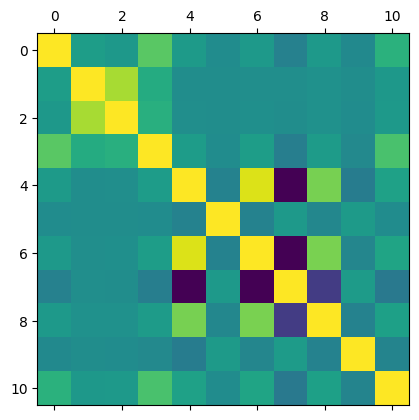

In [128]:
plt.matshow(train_df.corr()) 

label
amount.donated.2013
amount.donated.lifetime
no.donations.lifetime
Zipcode
international
Lat
Long
wages.per.capita
relationship.encoded
first.donated.scaled


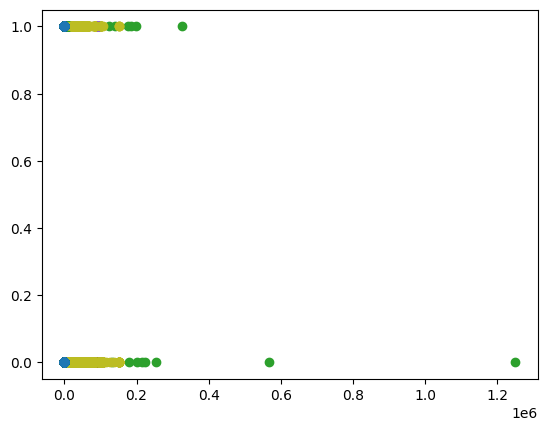

In [129]:
for column in train_df.columns:
    print(column) 
    plt.scatter(train_df[column],train_df['label'])

### Feature Engineering

Join tickets data with concert data to gain appreciation for what patrons went to which shows, and which conductors, composers… which will allow for predictions on the planned concerts based on same features. Could be a subordinate model producing a feature per account thst can be integrated into the existing model or could all get joined into the cbbdf

In [130]:
subs_df.head()

,no.seats,price.level,subscription_tier,multiple.subs,season.ordinal,pkg.CYO,pkg.Full,pkg.Full.upgrade,pkg.Quartet,pkg.Quartet.A,...,sn.Boxes.House.Left,sn.Boxes.House.Right,sn.Dress.Circle,sn.Floor,sn.Gallery,sn.Orchestra,sn.Orchestra.Front,sn.Orchestra.Rear,sn.Premium.Orchestra,sn.Santa.Rosa
account.id,,,,,,,,,,,,,,,,,,,,,
001i000000LhyR3,2,1.0,1.0,0.0,16,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
001i000000NuOeY,2,2.0,2.0,0.0,7,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
001i000000NuNvb,2,3.0,2.0,0.0,8,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001i000000NuOIz,1,2.0,0.5,0.0,0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
001i000000NuNVE,2,4.0,2.0,0.0,5,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [131]:
len(subs_df.index.unique()) 

6267

In [132]:
tickets_df.head()

,no.seats,set,season.ordinal,location.Berkeley.Saturday,location.Berkeley.Sunday,location.Contra.Costa,location.Family.concert,location.Peninsula,location.San.Francisco,multiple.tix.ordinal,...,Dominique.Labelle,Thomas.Cooley,Steven.Isserlis,Dashon.Burton,Rachel.Podger,BACH,HAYDN,VIVALDI,TELEMANN,HANDEL
account.id,,,,,,,,,,,,,,,,,,,,,
001i000000NuOP0,2,4,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
001i000000NuOYU,1,6,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
001i000000NuRS9,2,3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
001i000000NuRPj,1,2,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001i000000NuRQ1,2,1,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Scaling

In [133]:
account_df.head()

,amount.donated.2013,amount.donated.lifetime,no.donations.lifetime,Zipcode,international,Lat,Long,wages.per.capita,relationship.encoded,first.donated.scaled
account.id,,,,,,,,,,
001i000000LhSrQ,0.0,0.0,0,94102,0,37.77,-122.41,28735.618120,0.0,0.000000
001i000000LhyPD,0.0,500.0,5,94303,0,37.45,-122.10,36474.409895,0.0,0.391632
001i000000LhyPE,0.0,783.0,7,94597,0,37.91,-122.07,38831.542145,0.0,0.859593
001i000000LhyPF,1500.0,28435.0,28,94610,0,37.81,-122.24,41587.634136,0.0,0.369272
001i000000LhyPG,300.0,4969.0,16,94024,0,37.34,-122.11,76725.485700,0.0,0.610022


In [134]:
def scale(df, range=(0,1), omit=[]):
    for column in df.columns: 
        if column not in omit: 
            df[column] = min_max_scale(df, column, (0,1))

In [135]:
scale(account_df) 

In [136]:
account_df.head()

,amount.donated.2013,amount.donated.lifetime,no.donations.lifetime,Zipcode,international,Lat,Long,wages.per.capita,relationship.encoded,first.donated.scaled
account.id,,,,,,,,,,
001i000000LhSrQ,0.000000,0.000000,0.000000,0.942887,0.0,0.581972,0.232635,0.111788,0.0,0.000000
001i000000LhyPD,0.000000,0.000219,0.052632,0.944901,0.0,0.577042,0.234579,0.141893,0.0,0.391632
001i000000LhyPE,0.000000,0.000342,0.073684,0.947847,0.0,0.584129,0.234767,0.151063,0.0,0.859593
001i000000LhyPF,0.007096,0.012430,0.294737,0.947977,0.0,0.582589,0.233701,0.161785,0.0,0.369272
001i000000LhyPG,0.001419,0.002172,0.168421,0.942105,0.0,0.575347,0.234516,0.298479,0.0,0.610022


In [137]:
scale(subs_df, omit=['season.ordinal']) 

In [138]:
subs_df.head()

,no.seats,price.level,subscription_tier,multiple.subs,season.ordinal,pkg.CYO,pkg.Full,pkg.Full.upgrade,pkg.Quartet,pkg.Quartet.A,...,sn.Boxes.House.Left,sn.Boxes.House.Right,sn.Dress.Circle,sn.Floor,sn.Gallery,sn.Orchestra,sn.Orchestra.Front,sn.Orchestra.Rear,sn.Premium.Orchestra,sn.Santa.Rosa
account.id,,,,,,,,,,,,,,,,,,,,,
001i000000LhyR3,0.04,0.25,0.019608,0.0,16,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
001i000000NuOeY,0.04,0.50,0.058824,0.0,7,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
001i000000NuNvb,0.04,0.75,0.058824,0.0,8,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001i000000NuOIz,0.00,0.50,0.000000,0.0,0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
001i000000NuNVE,0.04,1.00,0.058824,0.0,5,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Clustering

In [139]:
from sklearn.decomposition import PCA

In [140]:
pca = PCA(n_components=2) 
pca.fit(account_df) 

PCA(n_components=2)

In [141]:
pca.singular_values_

array([69.96390802, 40.7698541 ])

In [142]:
account_df.head()

,amount.donated.2013,amount.donated.lifetime,no.donations.lifetime,Zipcode,international,Lat,Long,wages.per.capita,relationship.encoded,first.donated.scaled
account.id,,,,,,,,,,
001i000000LhSrQ,0.000000,0.000000,0.000000,0.942887,0.0,0.581972,0.232635,0.111788,0.0,0.000000
001i000000LhyPD,0.000000,0.000219,0.052632,0.944901,0.0,0.577042,0.234579,0.141893,0.0,0.391632
001i000000LhyPE,0.000000,0.000342,0.073684,0.947847,0.0,0.584129,0.234767,0.151063,0.0,0.859593
001i000000LhyPF,0.007096,0.012430,0.294737,0.947977,0.0,0.582589,0.233701,0.161785,0.0,0.369272
001i000000LhyPG,0.001419,0.002172,0.168421,0.942105,0.0,0.575347,0.234516,0.298479,0.0,0.610022


In [143]:
account_df.shape

(19833, 10)

In [144]:
lowD = pca.transform(account_df) 

In [145]:
from sklearn.cluster import KMeans

km_model = KMeans(n_clusters=8, random_state=0, n_init="auto")
km_model.fit(lowD) 

KMeans(random_state=0)

In [146]:
subD = account_df.copy()

In [147]:
subD['cluster'] = km_model.labels_ 

In [148]:
subD['lowD0'] = lowD.transpose()[0]
subD['lowD1'] = lowD.transpose()[1]

In [149]:
subD.head()

,amount.donated.2013,amount.donated.lifetime,no.donations.lifetime,Zipcode,international,Lat,Long,wages.per.capita,relationship.encoded,first.donated.scaled,cluster,lowD0,lowD1
account.id,,,,,,,,,,,,,
001i000000LhSrQ,0.000000,0.000000,0.000000,0.942887,0.0,0.581972,0.232635,0.111788,0.0,0.000000,0,0.194157,-0.211372
001i000000LhyPD,0.000000,0.000219,0.052632,0.944901,0.0,0.577042,0.234579,0.141893,0.0,0.391632,6,0.259935,0.177865
001i000000LhyPE,0.000000,0.000342,0.073684,0.947847,0.0,0.584129,0.234767,0.151063,0.0,0.859593,5,0.341357,0.638963
001i000000LhyPF,0.007096,0.012430,0.294737,0.947977,0.0,0.582589,0.233701,0.161785,0.0,0.369272,6,0.267832,0.173250
001i000000LhyPG,0.001419,0.002172,0.168421,0.942105,0.0,0.575347,0.234516,0.298479,0.0,0.610022,2,0.313355,0.401581


In [150]:
train_sub = subD.join(y_train, how='inner') 

In [151]:
pos_train_sub = train_sub[train_sub['label'] == 1]
neg_train_sub = train_sub[train_sub['label'] == 0]

In [152]:
pos_train_sub.shape

(332, 14)

In [153]:
neg_train_sub.shape

(6609, 14)

In [154]:
y_train.value_counts()

label
0    6609
1     332
Name: count, dtype: int64

In [155]:
test_sub = subD.join(X_test, how='inner', rsuffix='_') 

In [156]:
train_sub.shape

(6941, 14)

In [157]:
test_sub.shape

(2975, 23)

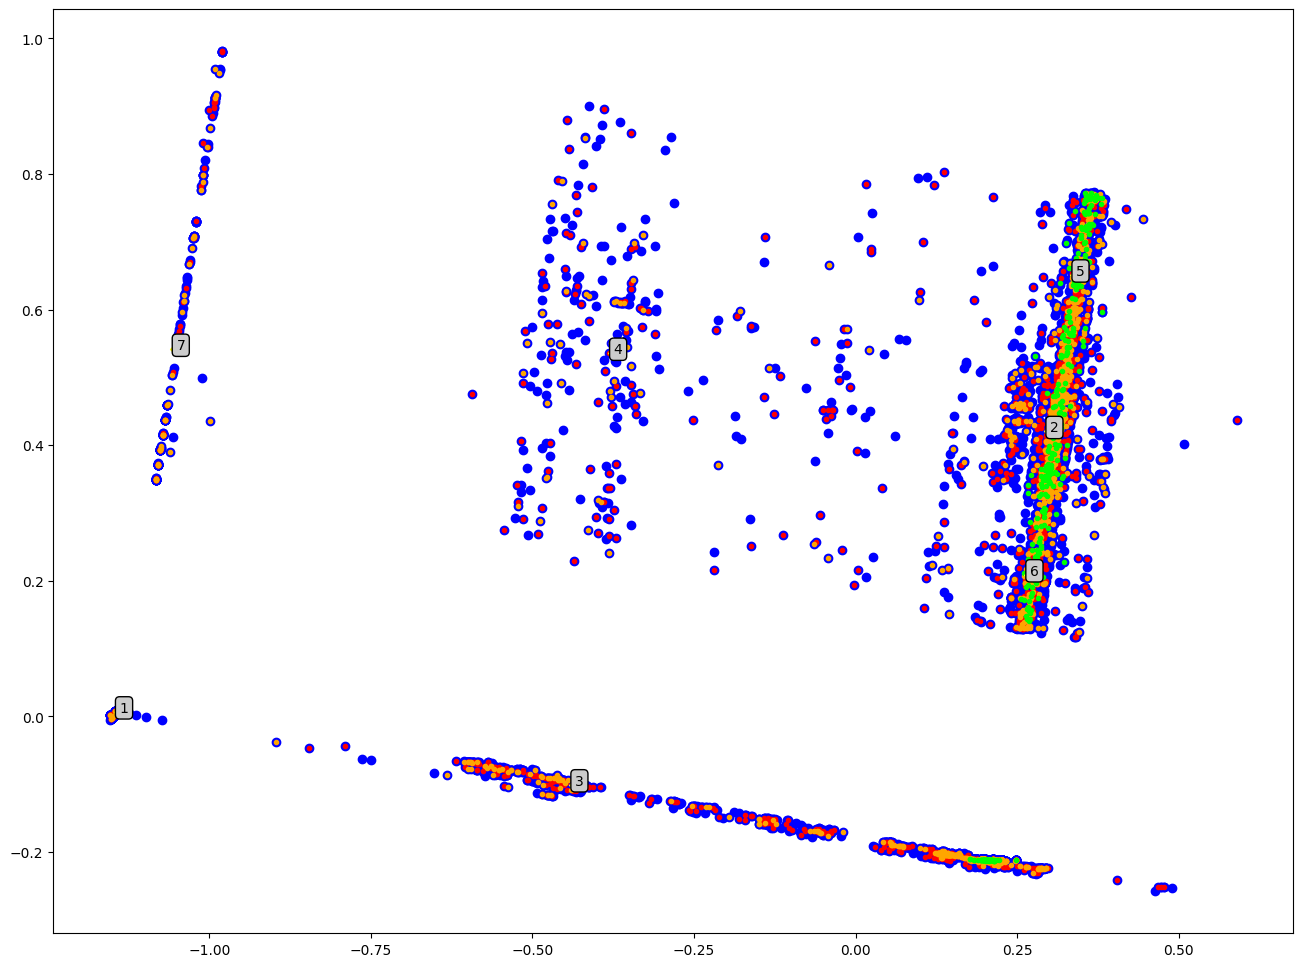

In [158]:
# Courtest of https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html#sphx-glr-auto-examples-decomposition-plot-pca-vs-lda-py
fig = plt.figure() 
fig.set_size_inches(16,12) 

# All accounts in low-d space 
plt.scatter(lowD[:, 0], lowD[:, 1], color='blue') 

# training - negative class
plt.scatter(neg_train_sub['lowD0'], neg_train_sub['lowD1'], color='red', marker='.') 

# test set
plt.scatter(test_sub['lowD0'], test_sub['lowD1'], marker='.', color='orange') 

# training - positive class
plt.scatter(pos_train_sub['lowD0'], pos_train_sub['lowD1'], color='lime', marker='.') 

for cluster in range(1,km_model.n_clusters): 
    center = km_model.cluster_centers_[cluster] 
    plt.scatter(center[0], center[1], color='yellow', marker='D') 
    plt.annotate(cluster, (center[0], center[1]), bbox=dict(boxstyle="round", fc="0.8"))

❗️ AHA! Clusters 5, 2 6 and a right section of 3 capture all of our true labels. They are also occupying a clearly linear slice of this low-dimension representation. 

Apply the labels for these clusters back to the dataframe it came from and see if anything interesting emerges here. Perhaps the clusters align with something we can clearly divide the modeling task by. Again, probably time to move this to a python app, there are just too many of these experiments to run. Every time I have a good idea I need to record in an experiment and have it rerun when we modify the data so we can grid search, etc. 

,amount.donated.2013,amount.donated.lifetime,no.donations.lifetime,Zipcode,international,Lat,Long,wages.per.capita,relationship.encoded,first.donated.scaled,cluster,lowD0,lowD1
account.id,,,,,,,,,,,,,
001i000000LhyZV,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,-1.138763,0.006995
001i000000Li857,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,-1.138763,0.006995
001i000000Li92i,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,-1.138763,0.006995
001i000000Li93q,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,-1.138763,0.006995
001i000000Li93r,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,-1.138763,0.006995


,amount.donated.2013,amount.donated.lifetime,no.donations.lifetime,Zipcode,international,Lat,Long,wages.per.capita,relationship.encoded,first.donated.scaled,cluster,lowD0,lowD1
count,2757.0,2757.0,2757.0,2757.000000,2757.000000,2757.000000,2757.000000,2757.0,2757.000000,2757.0,2757.0,2757.000000,2757.000000
mean,0.0,0.0,0.0,0.000356,0.010156,0.000103,0.999850,0.0,0.020433,0.0,1.0,-1.138773,0.006703
std,0.0,0.0,0.0,0.010552,0.100282,0.005400,0.007887,0.0,0.091666,0.0,0.0,0.010104,0.001981
min,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.585883,0.0,0.000000,0.0,1.0,-1.154270,-0.047219
25%,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,1.0,-1.138763,0.006995
50%,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,1.0,-1.138763,0.006995
75%,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,1.0,-1.138763,0.006995
max,0.0,0.0,0.0,0.417346,1.000000,0.283513,1.000000,0.0,1.000000,0.0,1.0,-0.789972,0.008207


<Axes: ylabel='account.id'>

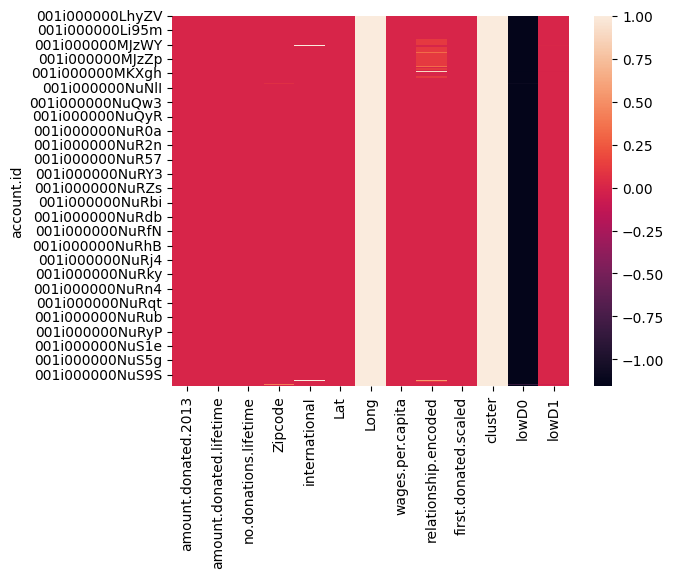

In [159]:
df = subD[subD['cluster'] == 1]
display(df.head()) 
display(df.describe()) 
sns.heatmap(df)

## Modeling

❗️❗️❗️ Look at the distribution of features with respect to the target variable ... does that tell us anything about how to proceed? Do we need a polyfit on some of the variables? What other transformations would assist? Keep working on homework and return here. 

What are our options for algorithms? 
- Linear regression
    - could be useful if we want to yield some type of score on e.g. historical purchases that then feeds into a classifier
- Logistic regression
    - baseline choice for classifications
- Support vector machine
    - should be considered, include this in a comparison
- Random forest
- KNN
    - should be considered, compared
- ❗️ Go through weeks 5, 6, 8 -- what other algorithms and approaches have been suggested?  

❗️ The different modes in the data, some accounts with rich history of ticket purchases, others with none, for example, suggests possibly different modeling strategies that are fused in an ensemble as suggested. What is the right way to join the probabilities and how do we know which to trust. Voting, etc... see sklearn ensemble guide. 

❗️ Probably need to transition to the pure python implementation now and start being more rigorous about test runs, train/test splits (k-folds probably), comparisons, and hyperparameter variation with plots to help determine the right path. The challenge is viewing the plots, will those just pop up in a window if we ask matplotlib to plot something? Yes it will. 

### Random Classifier

In [160]:
from sklearn.dummy import DummyClassifier, DummyRegressor

In [161]:
from sklearn import metrics

In [162]:
import random

In [163]:
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

@ignore_warnings(category=ConvergenceWarning)
def fit(model, X, y): 
    model.fit(X, y) 
    
def predict(model, X): 
    preds = model.predict(X)
    return preds

def predict_proba(model, X): 
    probs = model.predict_proba(X)
    return probs

def predict_random_proba(X): 
    probs = [random.random() for x in X.iterrows()]
    return probs

In [164]:
dummy_classifier = DummyClassifier(strategy='stratified')
fit(dummy_classifier, train_df.index, train_df['label'])
probs = predict_proba(dummy_classifier, train_df.index) 

In [165]:
dummy_regressor = DummyRegressor(strategy='constant', constant=0.7) 
fit(dummy_regressor, train_df.index, train_df['label'])
probs = predict(dummy_regressor, train_df.index)

In [166]:
probs = predict_random_proba(train_df) 

In [167]:
metrics.roc_auc_score(train_df['label'], probs) 

np.float64(0.49221352044583233)

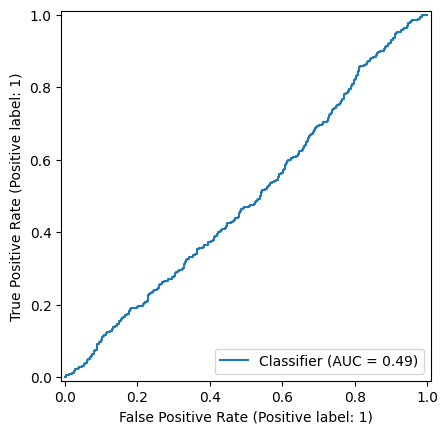

In [168]:
metrics.RocCurveDisplay.from_predictions(train_df['label'].to_numpy(), probs) 

### Logistic Regression

- move across the time series, fitting and evaluation as we go to learn what works and doesn't while we iterate on feature engineering 
- add regularization?
- add polynomial fit?

**Account data** 

In [169]:
from sklearn.linear_model import LogisticRegression

In [170]:
lr_model = LogisticRegression(penalty=None) 
fit(lr_model, X_train, y_train) 

In [171]:
lr_model.classes_

array([0, 1])

In [172]:
probs = predict_proba(lr_model, X_train)

In [173]:
positive_probs = probs[:,1]

In [174]:
metrics.roc_auc_score(y_train.values, positive_probs) 

np.float64(0.7413170612545508)

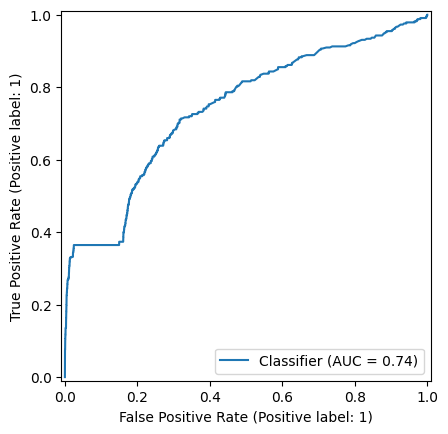

In [175]:
metrics.RocCurveDisplay.from_predictions(y_train.values, positive_probs) 

❗️ Some changes between Sunday and Monday/Tuesday early am reduced the auroc of this classifier when looking at the training data... figure out what and see what it teaches us. 

In [176]:
probs = predict_proba(lr_model, X_test) 

In [177]:
submit_df = pd.DataFrame() 
submit_df['ID'] = X_test.index
submit_df['Predicted'] = probs[:,1]

In [178]:
submit_df.to_csv('submissions/09march_0949.csv', index=False)

**Ticket Data Only** 

Let's see what the information for tickets alone give us in terms of predictions

In [179]:
tickets_df.dropna(inplace=True) 

In [180]:
train_tickets = tickets_df.join(train_df, how='inner')

In [181]:
X_train_tickets = train_tickets.drop(['label'], axis=1)

In [182]:
y_train_tickets = train_tickets[['label']]

In [263]:
td_lr_model = LogisticRegression(penalty='l2')
fit(td_lr_model, X_train_tickets, y_train_tickets) 

/Users/jason/Local/school/520/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [264]:
probs = predict_proba(td_lr_model, X_train_tickets) 
positive_probs = probs[:,1]
metrics.roc_auc_score(y_train_tickets.values, positive_probs)

np.float64(0.7313034971875765)

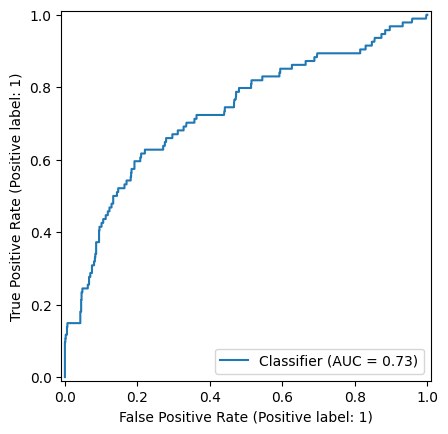

In [265]:
metrics.RocCurveDisplay.from_predictions(y_train_tickets.values, positive_probs) 

Well, the ticket data has some information latent in it perhaps, though the performance here is on the training data so perhaps it's just memorizing the answer we want it to learn. Next obvious move is to enrich the CBBDF with a count of how many composers/POIs they've paid money to see

In [248]:
from sklearn.model_selection import GridSearchCV

In [272]:
parameters = { 
    'penalty' : (None, 'l1', 'l2', 'elasticnet'), 
    'C' : [x / 10 for x in range(0,10)]
}
parameters2 = { 
    'penalty' : ['l1', 'l2'], 
    'C' : [1]
}
magic = GridSearchCV(
    estimator=LogisticRegression(), 
    param_grid=parameters2, 
    cv=5,
    scoring='roc_auc')
magic.fit(X_train_tickets, y_train_tickets)

/Users/jason/Local/school/520/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jason/Local/school/520/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jason/Local/school/520/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1], 'penalty': ['l1', 'l2']}, scoring='roc_auc')

In [273]:
magic.cv_results_

{'mean_fit_time': array([0.00061207, 0.07514863]),
 'std_fit_time': array([0.00043474, 0.0423022 ]),
 'mean_score_time': array([0.        , 0.00275202]),
 'std_score_time': array([0.        , 0.00218882]),
 'param_C': masked_array(data=[1, 1],
              mask=[False, False],
        fill_value=999999),
 'param_penalty': masked_array(data=['l1', 'l2'],
              mask=[False, False],
        fill_value=np.str_('?'),
             dtype=object),
 'params': [{'C': 1, 'penalty': 'l1'}, {'C': 1, 'penalty': 'l2'}],
 'split0_test_score': array([      nan, 0.4683908]),
 'split1_test_score': array([      nan, 0.7722323]),
 'split2_test_score': array([       nan, 0.70130067]),
 'split3_test_score': array([       nan, 0.73986691]),
 'split4_test_score': array([       nan, 0.74872286]),
 'mean_test_score': array([       nan, 0.68610271]),
 'std_test_score': array([       nan, 0.11122916]),
 'rank_test_score': array([2, 1], dtype=int32)}

**Subs DF**

Subs DF has a bunch of great information about historical subs, can we do a logistc regression model to predict over each of the last seasons who would buy tickets, then use that to provide an input to a prediction about this year's purchases? 

In [186]:
subs_df

,no.seats,price.level,subscription_tier,multiple.subs,season.ordinal,pkg.CYO,pkg.Full,pkg.Full.upgrade,pkg.Quartet,pkg.Quartet.A,...,sn.Boxes.House.Left,sn.Boxes.House.Right,sn.Dress.Circle,sn.Floor,sn.Gallery,sn.Orchestra,sn.Orchestra.Front,sn.Orchestra.Rear,sn.Premium.Orchestra,sn.Santa.Rosa
account.id,,,,,,,,,,,,,,,,,,,,,
001i000000LhyR3,0.04,0.25,0.019608,0.0,16,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
001i000000NuOeY,0.04,0.50,0.058824,0.0,7,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
001i000000NuNvb,0.04,0.75,0.058824,0.0,8,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001i000000NuOIz,0.00,0.50,0.000000,0.0,0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
001i000000NuNVE,0.04,1.00,0.058824,0.0,5,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
001i000000NuOE8,0.08,1.00,0.098039,0.0,1,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001i000000NuPnA,0.04,0.75,0.058824,0.0,13,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001i000000Lhyc6,0.12,0.75,0.137255,0.0,16,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [187]:
seasons = subs_df['season.ordinal'].unique()
seasons.sort()

In [188]:
def predict_subscribers(model, seasons, df, num_prior=1): 
    """
    Try to fit the provided model on the prior season(s) data to predict the current season's subscription renewals. 
    """
    results = [] 
    # Iterate over the seasons, in order, looking to see how we fare at predicting the current year's subscriptions based on the previous
    for season in seasons: 
        first_season = season - num_prior
        next_season = season + 1
        score = 0 
        if first_season in seasons and next_season in seasons: 
            prior_df = df[(df['season.ordinal'] >= first_season) & (df['season.ordinal'] < season)]
            this_df = df[df['season.ordinal'] == season]
            next_df = df[df['season.ordinal'] == next_season] 
            
            # Figure out which accounts from prior year(s) also subscribed this year
            current_subscribers = [1 if index in this_df.index else 0 for index in prior_df.index]
            future_subscribers = [1 if index in next_df.index else 0 for index in this_df.index]

            fit(model, prior_df, current_subscribers)
            
            # Check for utility 
            probs = predict_proba(model, this_df)[:,1]
            score = metrics.roc_auc_score(future_subscribers, probs)
            print(f"Season {season} result: {score:.4f}")
            results.append(score) 
            
    return results

In [189]:
scores = predict_subscribers(lr_model, seasons, subs_df, 1) 

Season 1 result: 0.6565
Season 2 result: 0.6855
Season 3 result: 0.6999
Season 4 result: 0.7046
Season 5 result: 0.7001
Season 6 result: 0.6518
Season 7 result: 0.6739
Season 8 result: 0.7609
Season 9 result: 0.6690
Season 10 result: 0.7410
Season 11 result: 0.6993
Season 12 result: 0.7495
Season 13 result: 0.7057
Season 14 result: 0.6873
Season 15 result: 0.6612
Season 16 result: 0.7066
Season 17 result: 0.6538
Season 18 result: 0.6779
Season 19 result: 0.6742


In [190]:
np.mean(scores)

np.float64(0.6925709738792624)

In [191]:
scores2 = predict_subscribers(LogisticRegression(penalty='l2'), seasons, subs_df, 2) 

Season 2 result: 0.6807
Season 3 result: 0.6953
Season 4 result: 0.7037
Season 5 result: 0.7019
Season 6 result: 0.6504
Season 7 result: 0.6800
Season 8 result: 0.7614
Season 9 result: 0.6842
Season 10 result: 0.7429
Season 11 result: 0.6991
Season 12 result: 0.7428
Season 13 result: 0.7037
Season 14 result: 0.6924
Season 15 result: 0.6683
Season 16 result: 0.7124
Season 17 result: 0.6692
Season 18 result: 0.7141
Season 19 result: 0.6741


In [192]:
np.mean(scores2)

np.float64(0.6987098387670466)

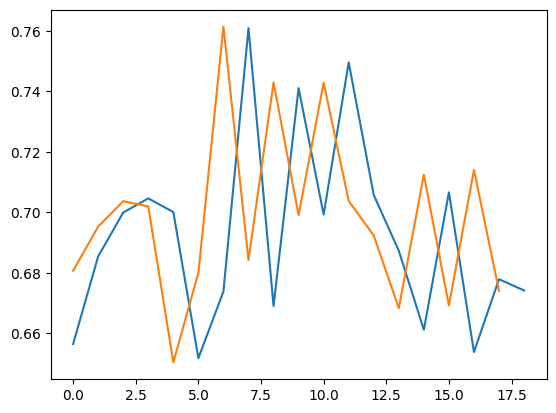

In [193]:
plt.plot(scores)
plt.plot(scores2) 

❗️ These results aren't amazing, and they are worse when we aggregate data from years past, but they do seem to carry some predictive power - perhaps we create a new column for each account which predicts next year's subs and adds the proba as a float value in the accounts DF. Well, there are only 1000 rows in the subsciption dataset for last year... significantly less than we need to predict, but perhaps we train separate models to predict with and without this info, as with the composers...

In [194]:
subs_df[subs_df['season.ordinal'] == 19].shape

(1058, 39)

**Low-D representation**

In [195]:
train_sub

,amount.donated.2013,amount.donated.lifetime,no.donations.lifetime,Zipcode,international,Lat,Long,wages.per.capita,relationship.encoded,first.donated.scaled,cluster,lowD0,lowD1,label
account.id,,,,,,,,,,,,,,
001i000000LhSrQ,0.000000,0.000000,0.000000,0.942887,0.0,0.581972,0.232635,0.111788,0.0,0.000000,0,0.194157,-0.211372,0
001i000000LhyPH,0.000000,0.000000,0.000000,0.943107,0.0,0.581356,0.232823,0.070770,0.0,0.000000,0,0.188990,-0.211304,1
001i000000LhyPI,0.004730,0.005208,0.210526,0.942085,0.0,0.575655,0.234328,0.335922,0.0,0.481132,6,0.298146,0.277903,1
001i000000LhyPS,0.001419,0.001123,0.157895,0.947506,0.0,0.583821,0.234015,0.246466,0.0,0.610635,2,0.314459,0.400286,1
001i000000LhyPT,0.002365,0.002592,0.273684,0.948057,0.0,0.583051,0.233764,0.214110,0.0,0.436413,6,0.284787,0.237582,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
001i0000017bRPX,0.000000,0.000000,0.000000,0.947506,0.0,0.583821,0.234015,0.246466,0.0,0.000000,0,0.213707,-0.212106,0
001i0000017bRa6,0.000000,0.000000,0.000000,0.942967,0.0,0.581510,0.232635,0.139714,0.0,0.000000,0,0.197411,-0.211393,0
001i0000017bRbx,0.000000,0.000000,0.000000,0.948959,0.0,0.583975,0.233576,0.176339,0.0,0.000000,0,0.206534,-0.212257,0


In [196]:
X_train_low = pd.DataFrame(index=train_sub.index, data=train_sub['lowD0']) 

In [197]:
X_train_low['lowD1'] = train_sub['lowD1']

In [198]:
X_train_low

,lowD0,lowD1
account.id,,
001i000000LhSrQ,0.194157,-0.211372
001i000000LhyPH,0.188990,-0.211304
001i000000LhyPI,0.298146,0.277903
001i000000LhyPS,0.314459,0.400286
001i000000LhyPT,0.284787,0.237582
...,...,...
001i0000017bRPX,0.213707,-0.212106
001i0000017bRa6,0.197411,-0.211393
001i0000017bRbx,0.206534,-0.212257


In [199]:
y_train_low = train_sub['label']

In [200]:
fit(lr_model, X_train_low, y_train_low) 

In [201]:
probs = predict_proba(lr_model, X_train_low)

In [202]:
positive_probs = probs[:,1]

In [203]:
metrics.roc_auc_score(y_train.values, positive_probs) 

np.float64(0.521322466443167)

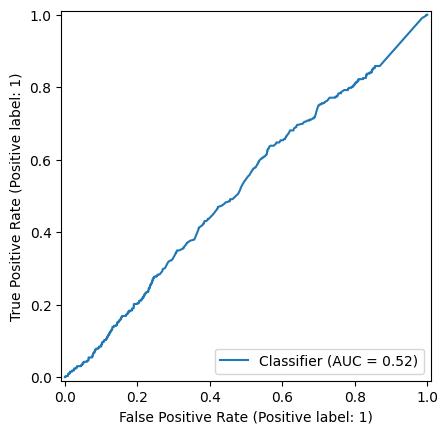

In [204]:
metrics.RocCurveDisplay.from_predictions(y_train.values, positive_probs) 

Shocking perhaps only me, using the lowD representation to classify results in garbage.

In [205]:
lr_model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': None,
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

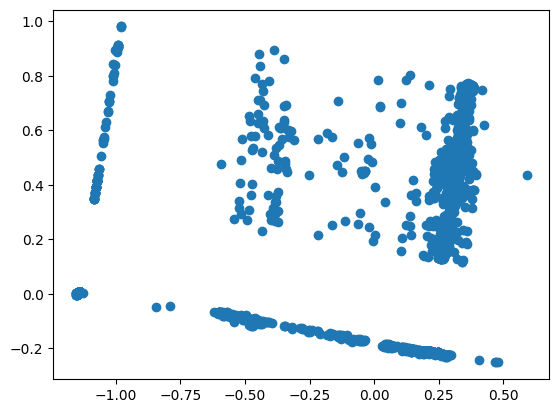

In [206]:
plt.scatter(x=X_train_low['lowD0'], y=X_train_low['lowD1'])

### Regularized Logistic Regression 

In [207]:
from sklearn.linear_model import Lasso
lasso_model = Lasso(alpha=0.1) 
fit(lasso_model, X_train, y_train) 

In [208]:
probs = predict(lasso_model, X_train) 

In [209]:
metrics.roc_auc_score(y_train.values, probs) 

np.float64(0.8709625155182692)

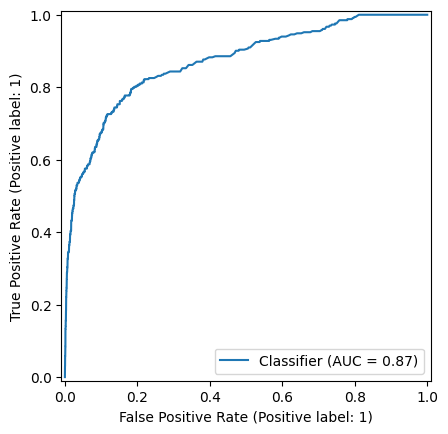

In [210]:
metrics.RocCurveDisplay.from_predictions(y_train.values, probs)

In [274]:
parameters = { 
    'penalty' : (None, 'l1', 'l2', 'elasticnet'), 
    'C' : range(0,10)
}
magic = GridSearchCV(
    estimator=LogisticRegression(), 
    param_grid=parameters, 
    cv=5,
    scoring='roc_auc')
magic.fit(X_train, y_train)

/Users/jason/Local/school/520/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jason/Local/school/520/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': range(0, 10),
                         'penalty': (None, 'l1', 'l2', 'elasticnet')},
             scoring='roc_auc')

In [275]:
magic.best_estimator_

LogisticRegression(C=1, penalty=None)

In [276]:
magic.best_score_

np.float64(0.7522632707592992)

### Random Forest

In [211]:
from sklearn.ensemble import RandomForestClassifier

In [212]:
rf_model = RandomForestClassifier()
fit(rf_model, X_train, y_train) 
probs = predict_proba(rf_model, X_train) 

In [213]:
positive_probs = probs[:, 1]

In [214]:
metrics.roc_auc_score(y_train.values, positive_probs) 

np.float64(0.9808858675737904)

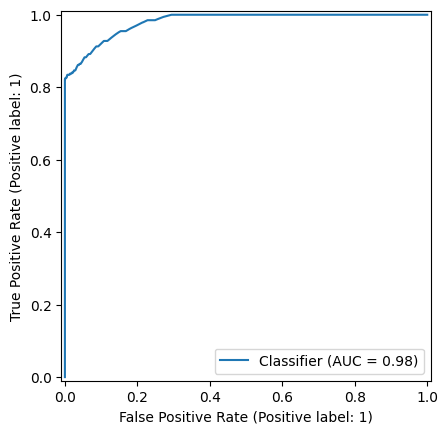

In [215]:
metrics.RocCurveDisplay.from_predictions(y_train.values, positive_probs)

In [216]:
probs = predict_proba(rf_model, X_test) 

In [217]:
submit_df = pd.DataFrame() 
submit_df['ID'] = X_test.index
submit_df['Predicted'] = probs[:,1]

In [218]:
submit_df.head()

,ID,Predicted
0,001i000000NuQ6Y,0.01
1,001i000000NuQXz,0.10
2,001i000000NuRDC,0.36
3,001i000000NuQeg,0.02
4,001i000000NuOQc,0.26


In [219]:
submit_df.shape

(2975, 2)

In [220]:
submit_df.to_csv('submissions/09march_0954.csv', index=False)

### SVM 

In [221]:
from sklearn.svm import SVC

In [222]:
# Should we use standardscaler here in lieu of minmaxscaler (see above)? 

In [223]:
sv_model = SVC(gamma='scale', probability=True)

In [224]:
fit(sv_model, X_train, y_train) 

In [225]:
probs = predict_proba(sv_model, X_train) 

In [226]:
positive_probs = probs[:,1]

In [227]:
metrics.roc_auc_score(y_train.values, positive_probs) 

np.float64(0.7945435851440259)

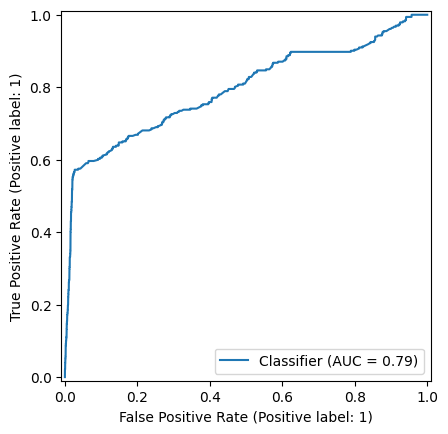

In [228]:
metrics.RocCurveDisplay.from_predictions(y_train.values, positive_probs)

In [229]:
submit_df = pd.DataFrame()
submit_df['ID'] = X_test.index
submit_df['Predicted'] = predict(sv_model, X_test) 

In [230]:
submit_df.shape

(2975, 2)

In [231]:
submit_df.to_csv('submissions/10march_2017.csv', index=False) 

### KNN

In [232]:
from sklearn.neighbors import KNeighborsClassifier
kn_model = KNeighborsClassifier(n_neighbors=1)

In [233]:
fit(kn_model, X_train, y_train)

In [234]:
probs = predict(kn_model, X_train)

In [235]:
metrics.roc_auc_score(y_train.values, probs) 

np.float64(0.9104757659781204)

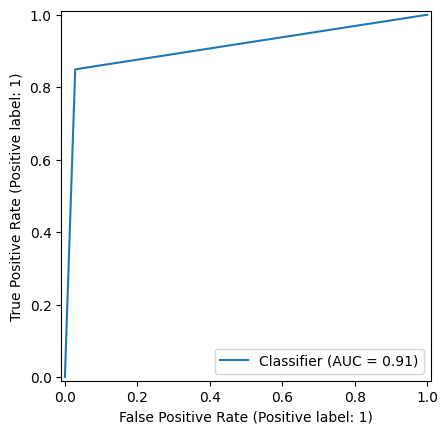

In [236]:
metrics.RocCurveDisplay.from_predictions(y_train.values, probs)

In [237]:
submit_df = pd.DataFrame()
submit_df['ID'] = X_test.index
submit_df['Predicted'] = predict(kn_model, X_test) 

In [238]:
submit_df.shape

(2975, 2)

In [239]:
submit_df.to_csv('submissions/12march2132.csv', index=False) 

## Submitting 

In [240]:
sample_df = pd.read_csv('data/sample_submission.csv') 
sample_df.head()

,ID,Predicted
0,001i000000NuQ6Y,0.5
1,001i000000NuQXz,0.5
2,001i000000NuRDC,0.5
3,001i000000NuQeg,0.5
4,001i000000NuOQc,0.5


In [241]:
sample_df.shape

(2975, 2)